In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import json
import pathlib
import pandas as pd
import numpy as np

from datetime import datetime


In [3]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager
%matplotlib inline

In [4]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [5]:
# where python source code located
import sys
code_path = os.path.abspath("../")

sys.path.append(code_path)

In [6]:
# utility modules or functions

from src.WellClass.libs.utils import (
    csv_parser,
    yaml_parser,
)

# WellClass
from src.WellClass.libs.well_class import Well
from src.WellClass.libs.well_pressure import Pressure

from src.WellClass.libs.grid_utils import (
    WellDataFrame,
    GridLGR,
    LGRBuilder,
)

# plots
from src.WellClass.libs.plotting import (
    plot_grid,
	plot_sketch,
    plot_pressure,

)


In [7]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# Set up case scenario

In [8]:
# root directory for pflotran 
pflotran_working_root = '../test_data/examples/wildcat-pflotran'

In [9]:
# # Examples
wildcat = {
        'well_input': r'wildcat.yaml', 
        # 'well_input': r'wildcat.csv',
        'template': r'TEMP-0',    # for dry run, defined in 'model' folder
        'sim_case': r'WILDCAT',          # for lgr run, defined in 'model' folder
        }

In [10]:
############# 0. User options ######################

# TODO(hzh): use Ali's grid logic
Ali_way = False

# the root path for simulation
sim_path = pathlib.Path(pflotran_working_root)

# configuration filename
well_input = pathlib.Path(wildcat['well_input'])

# dry run: filename prefix on coarse grid, e.g., TEMP-0_NOSIM
template_simcase = wildcat['template']

# lgr run: filename prefix on lgr grid, e.g., TEMP-0
sim_case_LGR = wildcat['sim_case']

# where pvt located
pvt_path = '../test_data/pvt_constants/'

In [11]:

############# 1. computed parameters ######################

# extract suffix from the configuration file name
file_extension = well_input.suffix

# .yaml or .csv?
use_yaml = False
if file_extension in ['.yaml', '.yml']:
    use_yaml = True


In [12]:

# file prefix for dry run
# where eclipse .EGRID and .INIT files will be located
temp_simcase = sim_path/'model'/template_simcase
temp_simcase

PosixPath('../test_data/examples/wildcat-pflotran/model/TEMP-0')

In [13]:
# LGR
simcase = sim_path/'model'/sim_case_LGR
simcase

PosixPath('../test_data/examples/wildcat-pflotran/model/WILDCAT')

# Setup new copies of the CIRRUS/PFLOTRAN *.in and *grdecl files

In [14]:
# Read the template PFLOTRAN input file
template_file = temp_simcase.with_suffix('.in')
#Set up/verify paths for the resulting files
model_dir = sim_path / 'model'
include_dir = sim_path / 'include'

#Create directories if they do not exist
model_dir.mkdir(parents=True, exist_ok=True)
include_dir.mkdir(parents=True, exist_ok=True)

#Define variables for mapping grdecl files
template_grdecl = include_dir / 'TEMP_GRD.grdecl'
simcase_grdecl = include_dir / f'{sim_case_LGR}_GRD.grdecl'

#Create files for the simulation

# Read the template grdecl file and create an edited version to be included on the simulation case
with open(template_grdecl) as file:
    lines = file.readlines()
    
lines[5] = f'--{lines[5]}'  # comment out include file line

with simcase_grdecl.open('w') as file:
    file.writelines(lines)


#Read the template input file and create an edited version for the simulation case
with open(template_file.with_suffix('.in')) as file:
    lines = file.readlines()


start_date = datetime(2025,1,1) # Set start date for simulation
end_date = datetime(2025,1,1) # Set end date for simulation
title = 'LEGACY Well experiment - SCREEN simulation' # Set title for simulation

# Replace lines with new values
lines[1] = f'!{title}\n'
lines[34] = f' START_DATE  {start_date.strftime("%d %b %Y").upper()}\n'
lines[35] = f' FINAL_DATE  {end_date.strftime("%d %b %Y").upper()} \n'
lines[23] = f'  TYPE grdecl ../include/{simcase_grdecl.name} \n'


with simcase.with_suffix('.in').open('w') as file:
    file.writelines(lines)




# Read wellbore data

In [15]:
############ 2. Load well configuration file ###############

# where well configuration file is located
well_name = sim_path/well_input

if use_yaml:

        # # pydantic model
        well_model = yaml_parser(well_name)
        well_csv = json.loads(well_model.spec.model_dump_json())
else:

        # load the well information
        well_csv = csv_parser(well_name)

In [16]:
########### 3. build Well class ######################
# build well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
        )
# to well dataframe
well_df = WellDataFrame(my_well)

# for convenience
# extract dataframes
annulus_df = well_df.annulus_df
drilling_df = well_df.drilling_df
casings_df = well_df.casings_df
borehole_df = well_df.borehole_df
barriers_mod_df = well_df.barriers_mod_df


In [17]:
my_pressure = Pressure(
    header      = well_csv['well_header'],
    reservoir_P = well_csv['reservoir_pressure'],
    co2_datum   = well_csv['co2_datum'],
    pvt_path    = pvt_path,
    max_pressure_pos = my_well.barriers
)

Hydrostatic pressure at reference depth 2238 is 224.24
RP1 set as hydrostatic P = 224.24 bar
RP2 is set as delta pressure, which yields P = 224.24 +20.00 = 244.24 bar
RP3 ignored
max_pressure_pos is a dictionary of barrriers
Pressure scenario RP1: Compute pressures assuming reservoir pressure is 224.24 bar at 2238.00 mTVDMSL
Pressure scenario RP2: Compute pressures assuming reservoir pressure is 244.24 bar at 2238.00 mTVDMSL
Pressure scenario max_p_cplug3: Compute maximum pressurization needed to reach Shmin at 123 mTVDMSL
Pressure scenario max_p_cplug2: Compute maximum pressurization needed to reach Shmin at 1823 mTVDMSL
Pressure scenario max_p_cplug1: Compute maximum pressurization needed to reach Shmin at 2273 mTVDMSL


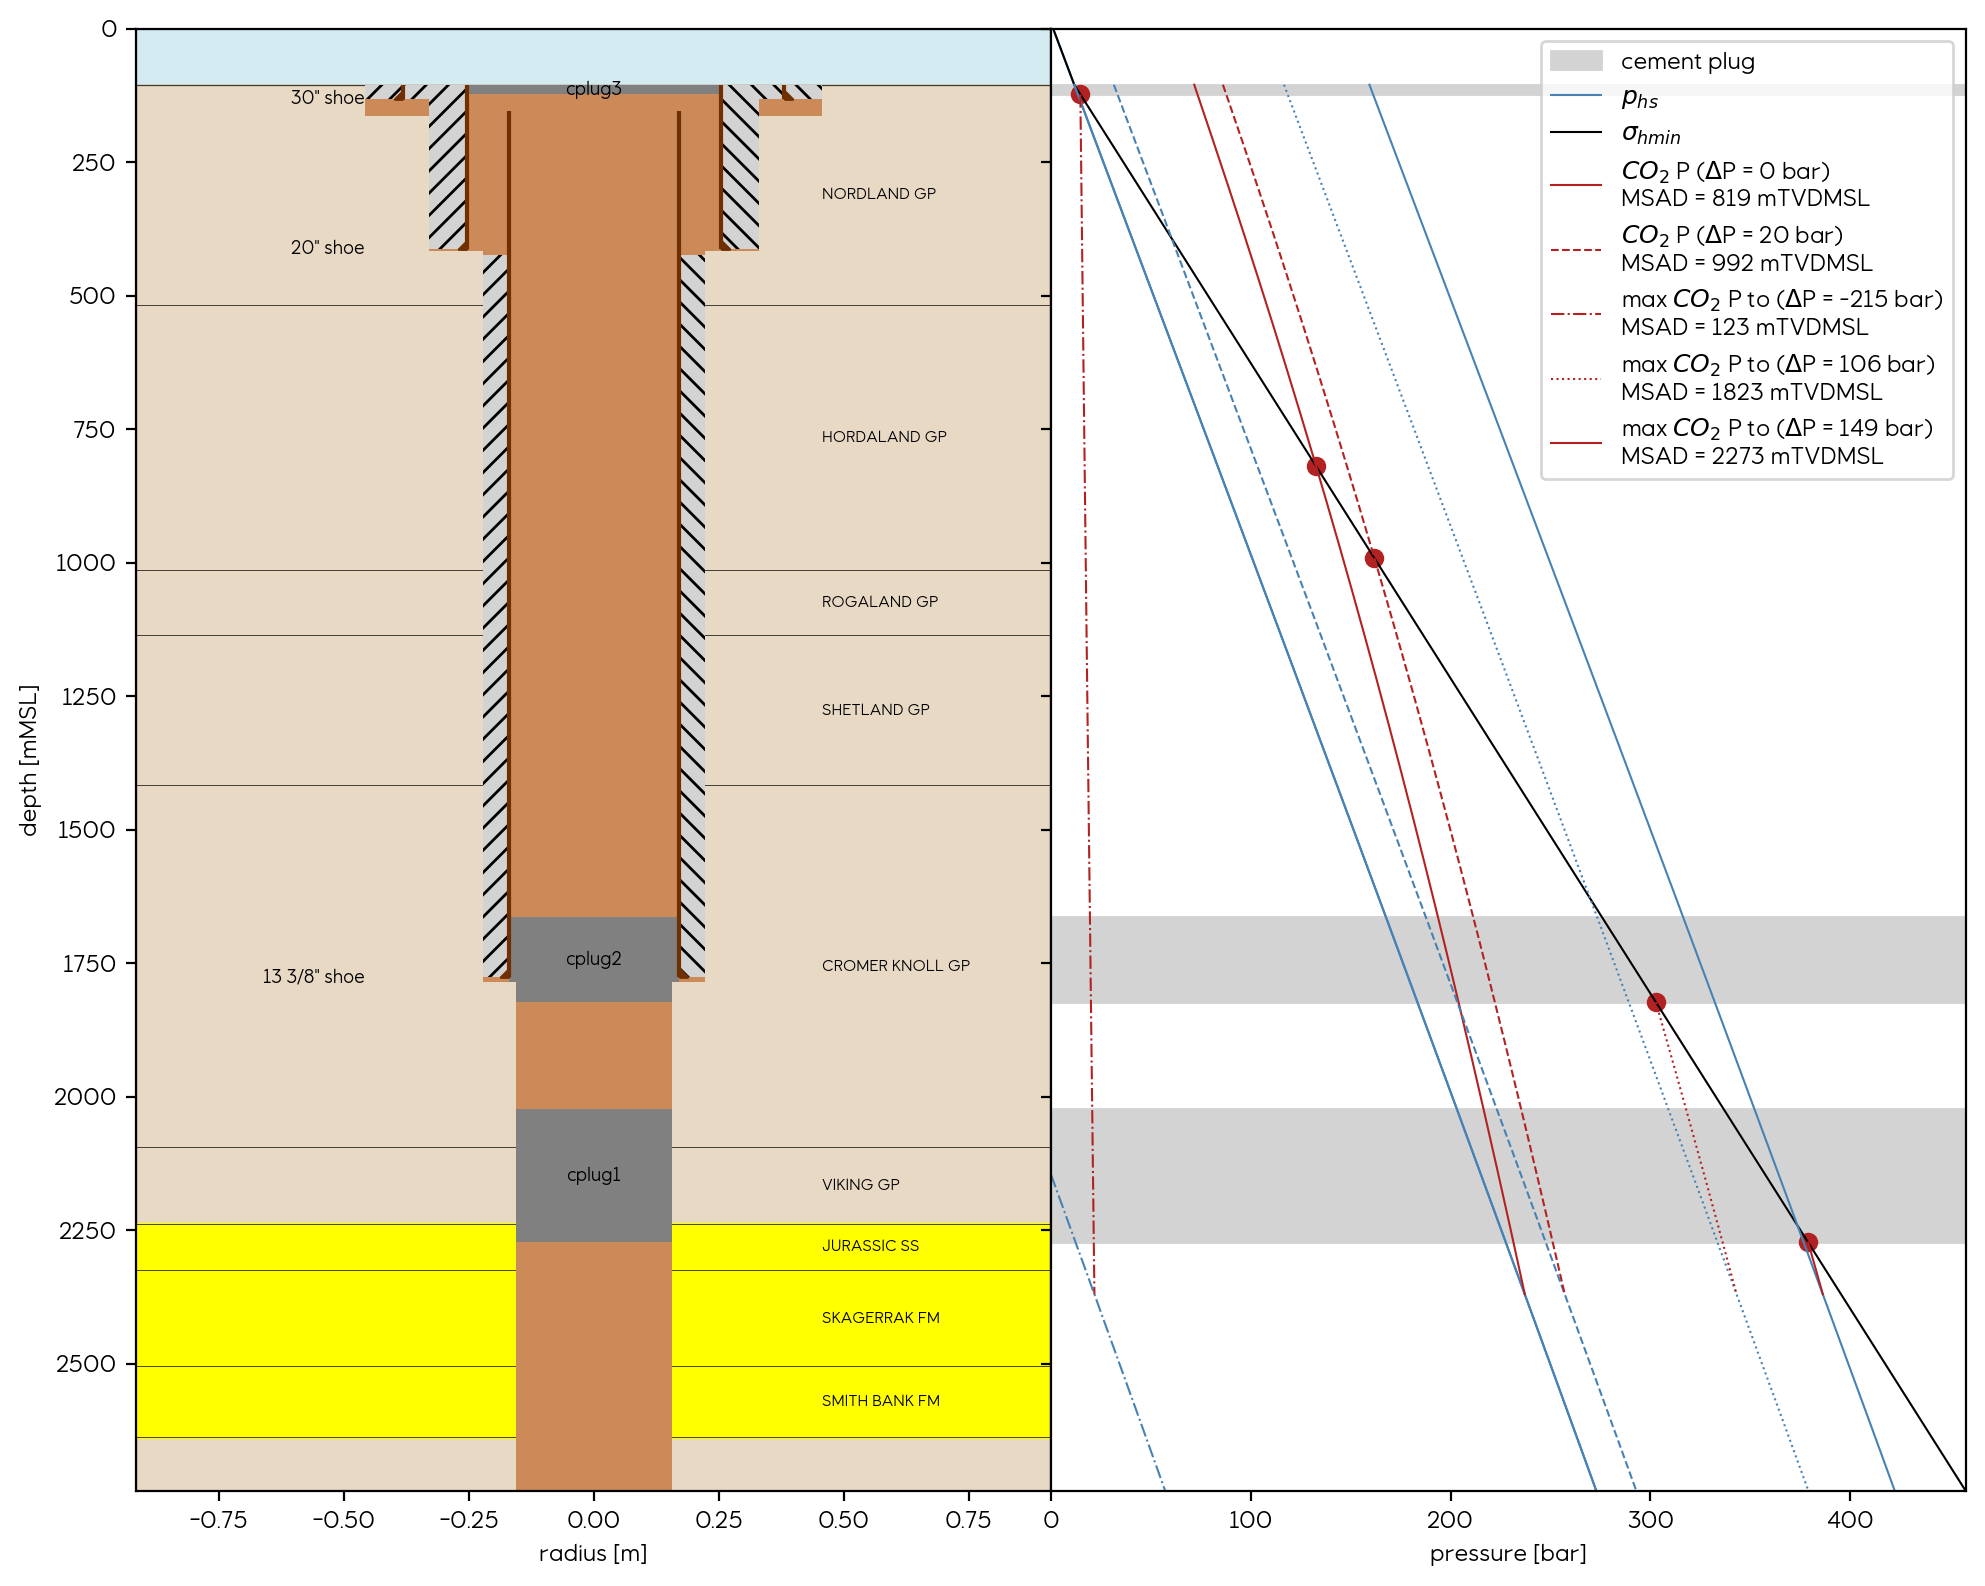

In [18]:
#Plot sketch, pressures
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 8))
plot_sketch(my_well, draw_open_hole=False, ax=ax1)
plot_pressure(my_pressure, my_well.geology, my_well.barriers, ax=ax2, 
              plot_HSP=True, #plot brine hydrostatic gradient
              plot_RP=True, #plot reservoir pressure scenarios
              plot_MSAD= True, #plot minimum safety abandonment depth
              plot_maxP=True #plot max expected pressures
              )

fig.tight_layout()
fig.subplots_adjust(wspace=0)


In [19]:
pd.DataFrame(my_pressure.pressure_scenarios)

,1,2,3,4,5
name,RP1,RP2,max_p_cplug3,max_p_cplug2,max_p_cplug1
p_resrv,224.236695,244.236695,21.673252,343.186462,386.361925
type,reservoir,reservoir,max_p,max_p,max_p
p_MSAD,132.681369,161.898989,14.629248,302.779248,379.054248
z_MSAD,819.472692,991.848034,123,1823,2273
z_resrv,2238,2238,2370,2370,2370
p_delta,0.0,20.0,-215.481128,106.032082,149.207544


In [20]:
my_well.co2_datum

2370

## Fecth info from well that will be used to define the vertical dimensions of the mesh

In [21]:
# Retrieve top reservoir depth
top_reservoir = well_df.geology_df.query('reservoir_flag == True')['top_msl'].min()

# Retrieve seafloor depth
top_overburden = my_well.header['sf_depth_msl']

# Define the thickness of the water column and the coarse overburden
water_column_thickness = top_overburden
coarse_overburden_thickness = (top_reservoir - top_overburden) - 5

# Define the thickness of the grid cells. 
tops_offset = 4
reservoir_cell_thickness = 5

grid_water_thickness = water_column_thickness - tops_offset
grid_coarse_thickness = (top_reservoir - top_overburden) - reservoir_cell_thickness #remove thickness of cap rock

#To make sure that no irrational numnbers are used we truncate the decimal places and add the residual to the top layer
cells_overburden_dz = grid_coarse_thickness // 9
cell_overbuden_dz_top = grid_coarse_thickness - (cells_overburden_dz * 8)

# Write the tops file
tops_file = include_dir / f'tops_dz.inc'

with open(tops_file, 'w') as f:
	f.write("EQUALS\n")
	f.write("TOPS 4 4* 1 1 /\n")
	f.write("/\n\n")
	f.write("DZ\n")
	f.write(f"400*{grid_water_thickness} 400*{cell_overbuden_dz_top} 3200*{cells_overburden_dz} 28000*{reservoir_cell_thickness} /\n")
	f.write("/\n")

## Update Equilibrium section

In [22]:
# Fetch values from Pressure and Well class to be included in the Equilibration section of *.in file
scenario_idx = 1
scenario_name = my_pressure.pressure_scenarios[scenario_idx]['name']

reservoir_wgc_d = my_well.co2_datum
reservoir_datum_d = reservoir_wgc_d
reservoir_pressure = np.interp(reservoir_wgc_d, my_pressure.pressure_CO2['init']['depth_msl'], my_pressure.pressure_CO2[scenario_name]['h2o'])

overburden_datum_d = 500
overburden_pressure = my_pressure.pressure_CO2['init'].loc[500]['hs_p']

In [23]:
# Define the temperature table
#Retrieve the temperature gradient and the surface temperature
sf_temp = my_well.header['sf_temp']
geo_tgrad = my_well.header['geo_tgrad']
sf_depth_msl = my_well.header['sf_depth_msl']

# Define the temperature table control points (top, seabed and bottom)
z_top_RTEMPVD = tops_offset
z_sf_RTEMPVD = top_overburden
z_bottom_RTEMPVD = grid_water_thickness + cell_overbuden_dz_top + (cells_overburden_dz * 8) + (reservoir_cell_thickness * 70) + tops_offset

# Define the deth column of the temperature table
z_RTEMPVT = np.linspace(z_sf_RTEMPVD, z_bottom_RTEMPVD, 8)
z_RTEMPVT = np.insert(z_RTEMPVT, 0, z_top_RTEMPVD)

# Calculate the temperature column
temp_RTEMPVT = sf_temp + (z_RTEMPVT-sf_depth_msl) * geo_tgrad/1000
temp_RTEMPVT[z_RTEMPVT <= sf_depth_msl] = sf_temp


# Create the RTEMPVD section string
new_rtempvd_section = "RTEMPVD\n    ! Metric\n"

for z, t in zip(z_RTEMPVT, temp_RTEMPVT):
	new_rtempvd_section += f"{z:11.2f} {t:8.2f}\n"



In [24]:
def setup_equilibration(name, d_datum, pressure, wgc_d, rtempvd, top, bottom):
	
  wgc_d_line = f"  WGC_D {wgc_d} m\n" if wgc_d is not None else ""
  
  equil_str = f"""
	
EQUILIBRATION {name}
  
  DATUM_D {d_datum} m
  PRESSURE {pressure:.2f} Bar	
  {wgc_d_line}
	
  TEMPERATURE_TABLE
    D_UNITS m !cannot be otherwise
    TEMPERATURE_UNITS C !cannot be otherwise
  
    {rtempvd}
	/  
  END

  SALT_TABLE
    D_UNITS m
    CONCENTRATION_UNITS MOLE
    SALTVD
      {top} 0.032
      {bottom} 0.032
    /
  END 
     
  GAS_IN_LIQUID_MOLE_FRACTION 0.0
/
	"""
  # Split the string into a list of lines and remove any leading/trailing whitespace on each line
  equil_lines = [line.rstrip() + '\n' for line in equil_str.strip().split('\n')]
  
  return equil_lines


equil_pmts = {
    'overburden_water': {
        'DATUM_D': overburden_datum_d,  
        'PRESSURE': overburden_pressure,  
        'WGC_D': None     
    },
    'CO2_column': {
        'DATUM_D': reservoir_datum_d,  
        'PRESSURE': reservoir_pressure,  
        'WGC_D': reservoir_wgc_d     
    }
}


with open(simcase.with_suffix('.in')) as file:
    lines = file.readlines()


new_lines = lines[:236]

for name, pmts in equil_pmts.items():
    
    equil_lines = setup_equilibration(name=name, pressure=pmts['PRESSURE'], d_datum = pmts['DATUM_D'], wgc_d= pmts['WGC_D'],  rtempvd=new_rtempvd_section, top=z_top_RTEMPVD, bottom=z_bottom_RTEMPVD)
    new_lines += equil_lines
    
new_lines += lines[316:]

with simcase.with_suffix('.in').open('w') as file:
    file.writelines(new_lines)


# Run coarse simulation

In [25]:
# file name (coarse grid) for pflotran run
run_config_coarse = simcase.with_suffix('.in')
run_config_coarse

PosixPath('../test_data/examples/wildcat-pflotran/model/WILDCAT.in')

In [26]:
%%bash -s "$run_config_coarse"

runcirrus -i -nm 6 $1


bash -c <SCRIPT>



 Cirrus 1.9sv3
 Cirrus was compiled on: Jan 16 2025 15:50:13            
 RESERVOIR_DEFAULTS keyword selected.
 Cirrus card:: DIMENS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: DZ                              
 Cirrus card:: EQUALS                          
 Cirrus card:: COPY                            
 Cirrus card:: MULTIPLY                        
 Cirrus card:: MINPV                           
 Calculating pore volumes
 Calculating connections
 Ncell=       32000  Nact=       32000  Nconn=       92400  Nflt=           0  Npo=           0
 Reading SUBSURFACE cards:
 Cirrus card:: GRID
 Cirrus card:: REFERENCE_PRESSURE
 Cirrus card:: REFERENCE_TEMPERATURE
 Cirrus card:: TIME
 Cirrus card:: OUTPUT
 Cirrus card:: NEWTON_SOLVER
 Cirrus card:: MATERIAL_PROPERTY
   Name :: formation
 "MATERIAL_PROPERTY,rock density units" set to default value.
 "MATERIAL_PROPERTY,specific heat units" set to default value.
 "MATERIAL_PROPERTY,dry thermal conduc

CalledProcessError: Command 'b'\nruncirrus -i -nm 6 $1\n'' returned non-zero exit status 87.

## Build LGR

In [ ]:

##### LGR grid 
lgr = LGRBuilder(simcase, 
                 annulus_df, 
                 drilling_df,
                 Ali_way)

In [ ]:
############### generate and output LGR #####################

LGR_NAME = f'LW_LGR'
output_dir = sim_path/'include'


# Write LGR file
gap_casing_df = lgr.build_grdecl(output_dir, 
                                 LGR_NAME,
                                 drilling_df,
                                 casings_df,
                                 barriers_mod_df)

gap_casing_df

# Run LGR simulation

In [289]:
# Update the grdecl file
with open(simcase_grdecl) as file:
    lines = file.readlines()

# Add the include file line so it reads the generated LGR file
lines[5] = f'external_file ../include/{LGR_NAME}.grdecl / \n'

with simcase_grdecl.open('w') as file:
    file.writelines(lines)


In [290]:
#Update the *.in file
with open(simcase.with_suffix('.in')) as file:
    lines = file.readlines()


# start_date = datetime(2025,1,1)
# end_date = datetime(2025,1,1+1)
# title = 'LEGACY Well experiment - SCREEN simulation'

# lines[1] = f'!{title}\n'
# lines[34] = f' START_DATE  {start_date.strftime("%d %b %Y").upper()}\n'
lines[35] = f' FINAL_DATE  {end_date.strftime("%d %b %Y").upper()} \n'
# lines[23] = f'  TYPE grdecl ../include/{simcase_grdecl.name} \n'






with simcase.with_suffix('.in').open('w') as file:
    file.writelines(lines)


In [ ]:
# file name (LGR grid) for pflotran run
run_config_lgr = simcase.with_suffix('.in')
run_config_lgr

In [ ]:
%%bash -s "$run_config_lgr"

runcirrus -i -nm 6 $1

### Load files from pflotran simulation

In [293]:
# load LGR grid from simulation file
grid_lgr = GridLGR(simcase)

In [ ]:
grid_lgr.lgr_index

# Visualization

In [ ]:
import inspect
inspect.getfile(plot_grid)

In [ ]:
# coarse grid
grid_coarse = lgr.grid_coarse

plot_grid(my_well, grid_coarse, prop='SATNUM', )

import matplotlib.pyplot as plt

plt.get_fignums()

In [297]:
import matplotlib.pyplot as plt

# Retrieve a list of all active figures
figures = [plt.figure(num) for num in plt.get_fignums()]

# Display the figures
for fig in figures:
    fig.show()

In [ ]:
# LGR grid from pflotran output
PROPS = 'TRANZ'
PROPS = 'PERMX'
PROPS = 'PERMX'
# plot it
plot_grid(my_well, grid_lgr, prop=PROPS)

In [ ]:
# LGR grid from dataframe
grid_refine = lgr.grid_refine

plot_grid(my_well, grid_refine)

# Other Qcs

In [ ]:
# testing plot_sketch
DEBUGGING = True
if DEBUGGING:
    from src.WellClass.libs.plotting import plot_sketch
    plot_sketch(my_well, 
                draw_annotation=False,
                draw_open_hole=True,
                draw_cement_bond=False,
                draw_casings=False, 
                draw_barriers=False)

In [29]:
ip_grid = grid_refine.mesh_df.sort_values(by=["k","j","i"])

In [ ]:
type(ip_grid)

In [31]:
# lgr mesh from simulation file
lgr_index = grid_lgr.lgr_index

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
prop = 'PERMX'
ax.scatter(ip_grid[prop], lgr_index[prop])
ax.set_xlabel(f'{prop} in grid.refine')
ax.set_ylabel(f'{prop} in grdecl')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=0.5, ls='--')

In [ ]:
fig, ax = plt.subplots()
prop = 'DX'
ax.scatter(ip_grid[prop], lgr_index[prop])
ax.set_xlabel(f'{prop} in grid.refine')
ax.set_ylabel(f'{prop} in grdecl')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=0.5, ls='--')

In [ ]:
fig, ax = plt.subplots()
prop = 'DZ'
ax.scatter(ip_grid[prop], lgr_index[prop])
ax.set_xlabel(f'{prop} in grid.refine')
ax.set_ylabel(f'{prop} in grdecl')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=0.5, ls='--')